In [1]:
from k1lib.imports import *

In [2]:
class SkipBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x) + x

In [3]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, blocks=2, block=SkipBlock):
        super().__init__()
        layers = []
        layers += [nn.Linear(1, hiddenDim), nn.LeakyReLU()]
        for i in range(blocks): layers += [block(hiddenDim)]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [39]:
def newL(bs=64, optF=None, *args, **kwargs):
    optF = lambda p: optim.Adam(p, lr=5e-3)
    l = k1lib.Learner()
    l.model = Network(*args, **kwargs)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    l.css = """
SkipBlock #0: HookParam
SkipBlock: HookModule
"""
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        plt.plot(xbs.cpu(), ys.detach().cpu(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [5]:
l = newL(hiddenDim=10, blocks=30)
l.run(10); l.save("10.pth")

Progress:   9%, epoch:  0/10, batch: 149/157, elapsed:   3.68s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth
Saved to 10.pth


In [14]:
l = newL(hiddenDim=100, blocks=30)
l.run(10); l.save("100.pth")

Progress:  39%, epoch:  3/10, batch: 148/157, elapsed:  18.72s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth
Saved to 100.pth


In [67]:
l = newL(hiddenDim=1000, blocks=10); l.cbs.withCuda()
l.run(10); l.save("1000-10.pth")

Progress: 100%, epoch:  9/10, batch: 156/157, elapsed:  33.09s  Saved to autosave-2.pth
Saved to 1000-10.pth


In [62]:
l = newL(hiddenDim=1000, blocks=5); l.cbs.withCuda()
l.run(10); l.save("1000-5.pth")

Progress: 100%, epoch:  9/10, batch: 156/157, elapsed:   18.0s  Saved to autosave-2.pth
Saved to 1000-5.pth


In [64]:
l = newL(hiddenDim=1000, blocks=2); l.cbs.withCuda()
l.run(10); l.save("1000-2.pth")

Progress:  39%, epoch:  3/10, batch: 148/157, elapsed:   3.64s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth
Saved to 1000-2.pth


## Analysis

In [68]:
l10 = k1lib.Learner.load("10.pth")
l100 = k1lib.Learner.load("100.pth")
l1 = k1lib.Learner.load("1000-2.pth")
l2 = k1lib.Learner.load("1000-5.pth")
l3 = k1lib.Learner.load("1000-10.pth")

Loaded from 10.pth
Loaded from 100.pth
Loaded from 1000-2.pth
Loaded from 1000-5.pth
Loaded from 1000-10.pth


### 10.pth, control

In [71]:
newL(hiddenDim=10, blocks=2).selector

ModuleSelector:
root: Network                     
    bulk: Sequential                     
        0: Linear                         
        1: LeakyReLU                         
        2: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: LeakyReLU                         
        3: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: Lea

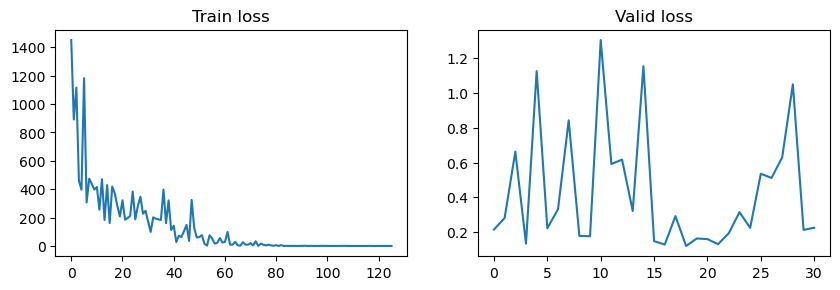

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [69]:
l10.Loss.plot()

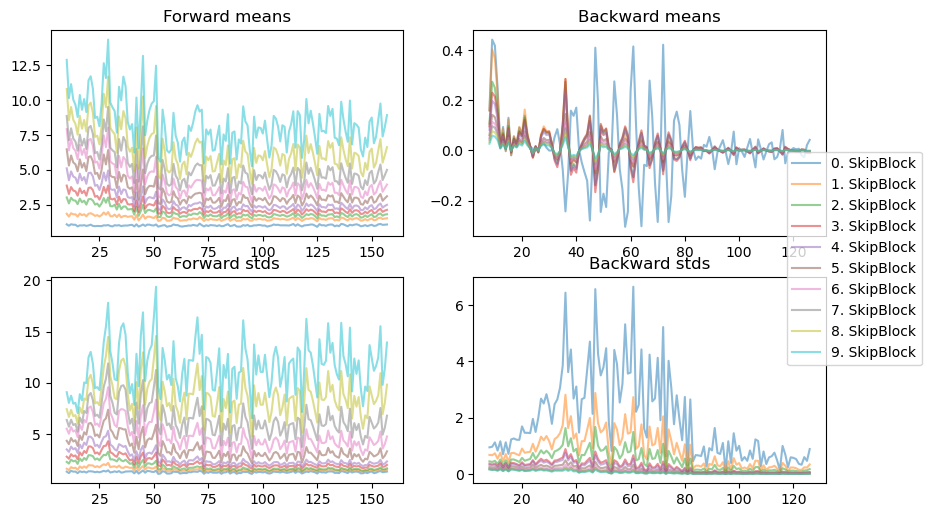

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [80]:
l10.HookModule[::3].plot()[10:]

Like everything else, initial values are kinda insane, so slice `[10:]` it is


Progress: 100%          8/8 Finished [-3.2, 3.2] range                          

/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


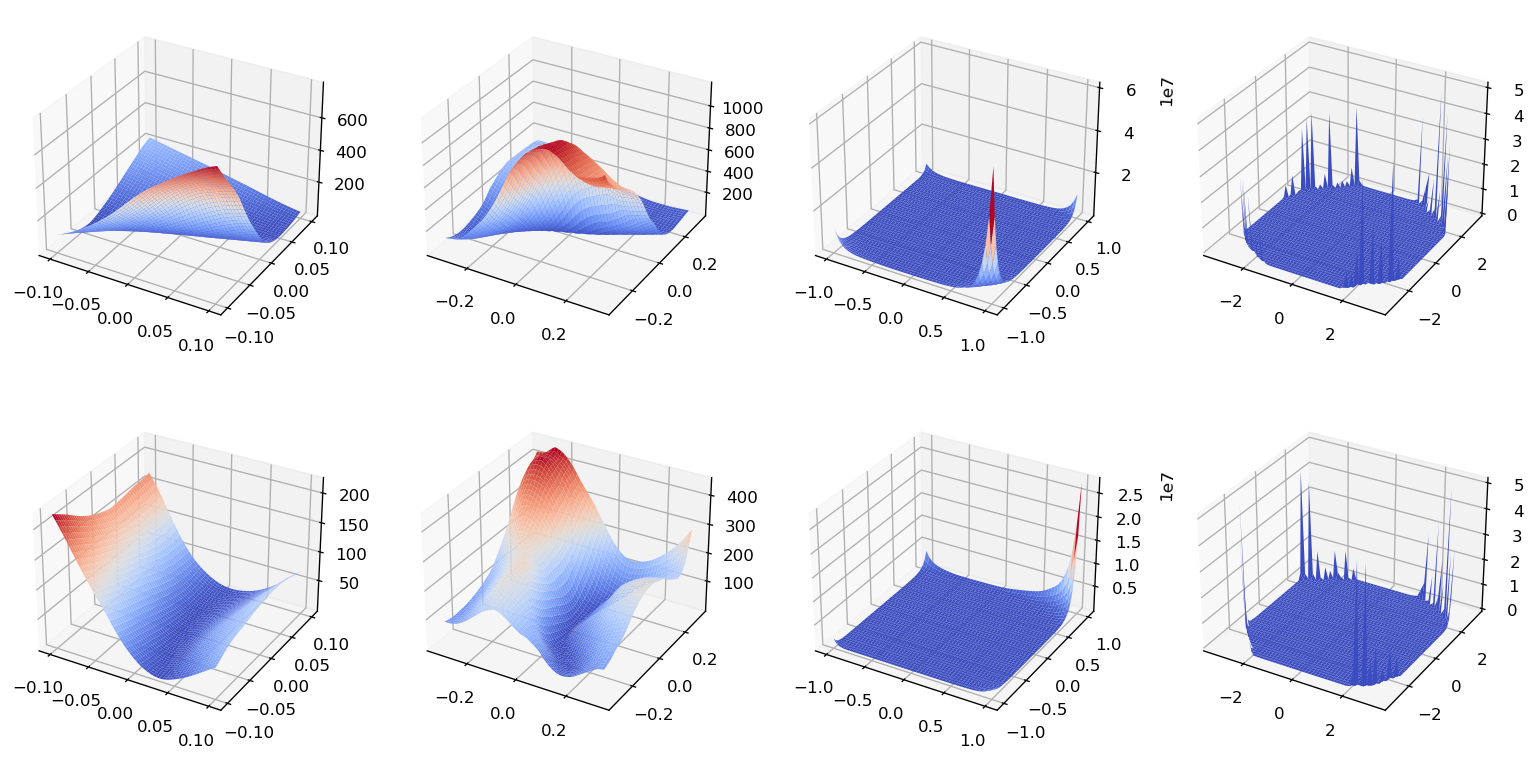

In [77]:
l10.LossLandscape.plot()

### 100.pth

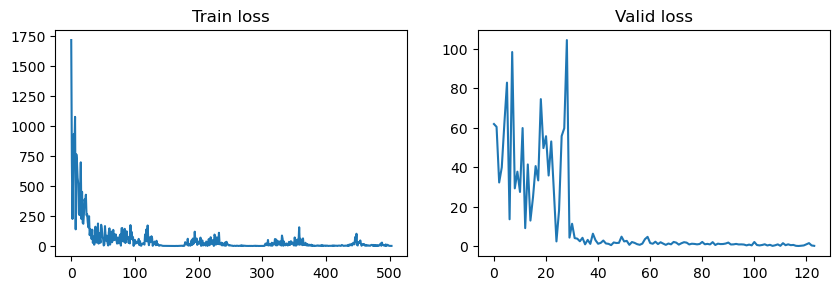

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [85]:
l100.Loss.plot()

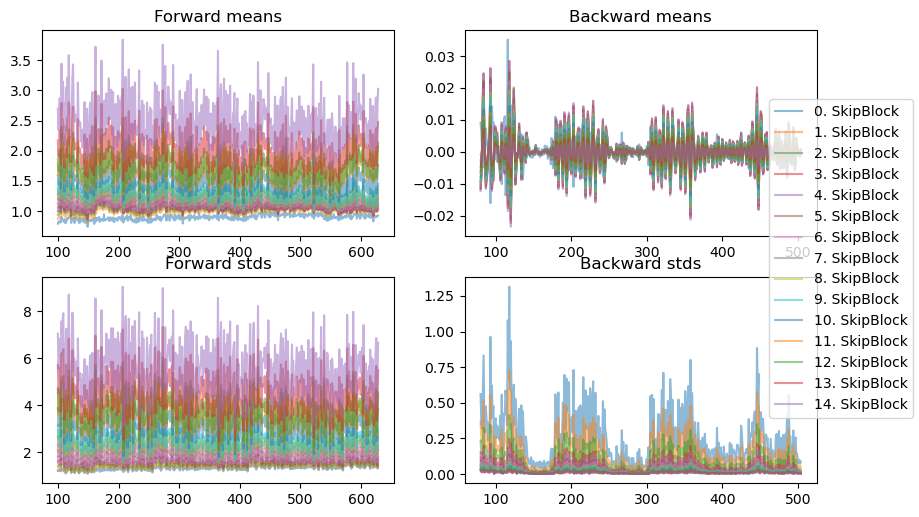

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [84]:
l100.HookModule[::2].plot()[100:]

In [ ]:
l100.LossLandscape.plot()

### 1000-10.pth

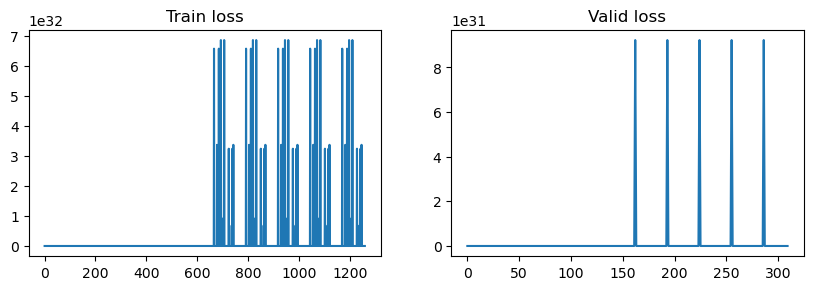

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [88]:
l3.Loss.plot()

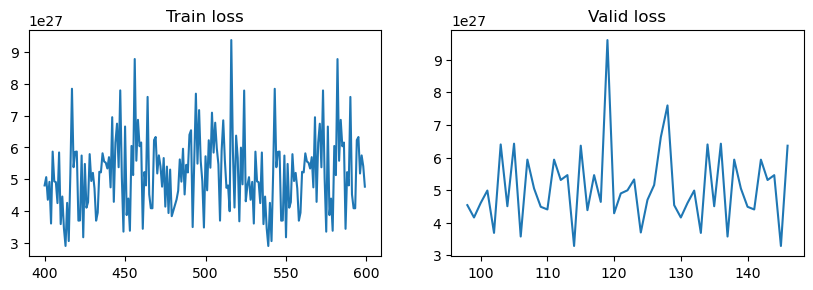

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [91]:
l3.Loss.plot()[400:600]

Even zooming in a quiet place, it's still 1e27. Yeah clearly this doesn't work.

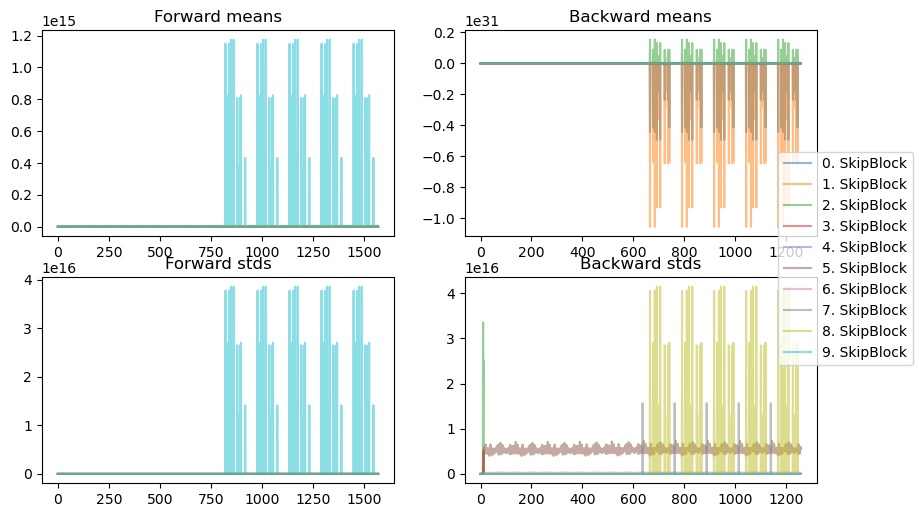

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [90]:
l3.HookModule.plot()

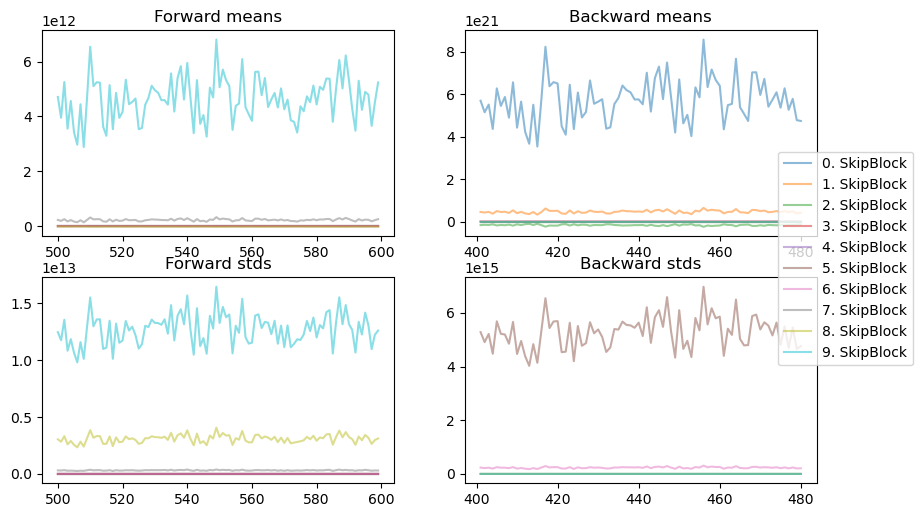

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [92]:
l3.HookModule.plot()[500:600]

Same thing with HookModule

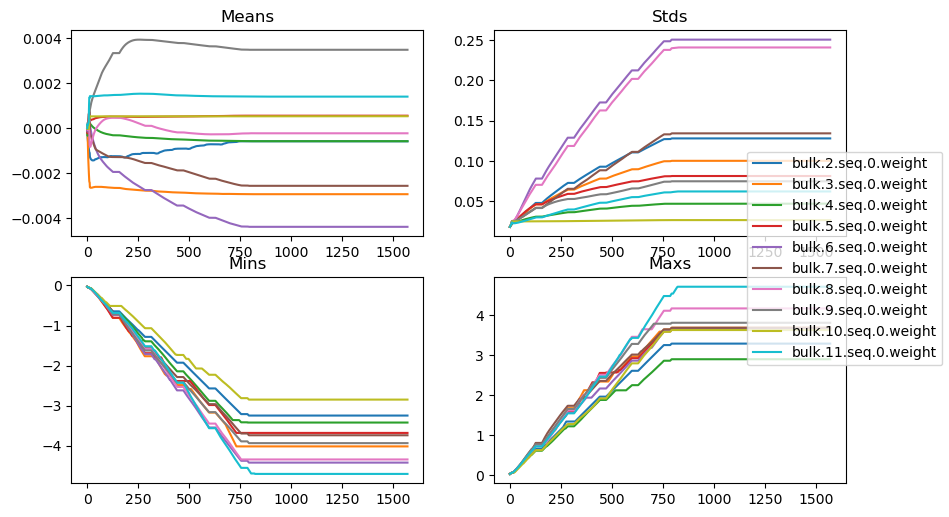

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [147]:
l3.HookParam[::2].plot()

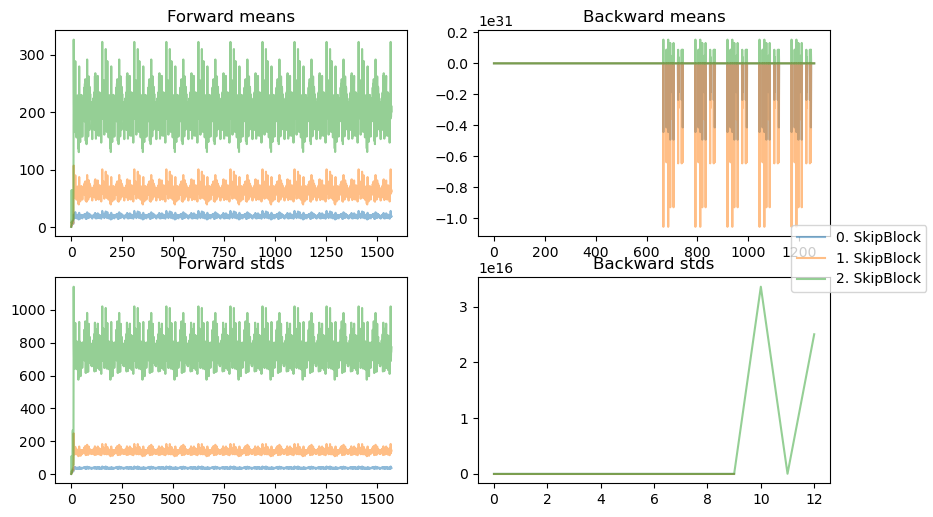

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [146]:
l.HookModule[:3].plot()[:]

Parameter's values doesn't look that horrifying though. Not sure what's happening here

### 1000-2.pth

### 1000-5.pth

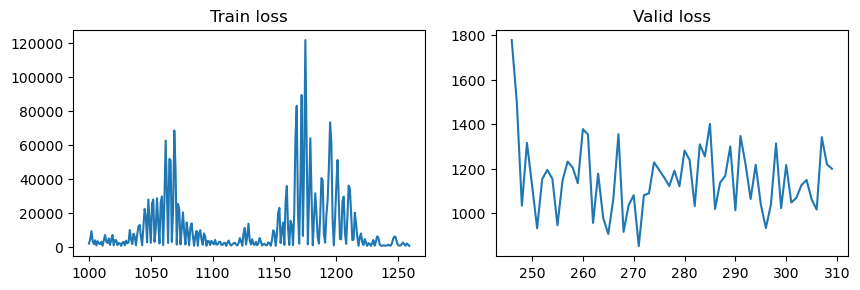

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [51]:
l.Loss.plot()[1000:]

Epoch cancelled: .


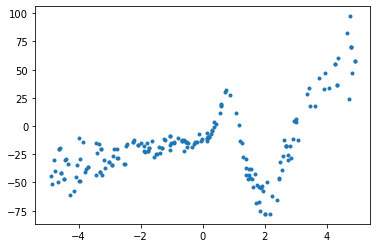

In [46]:
l.evaluate()

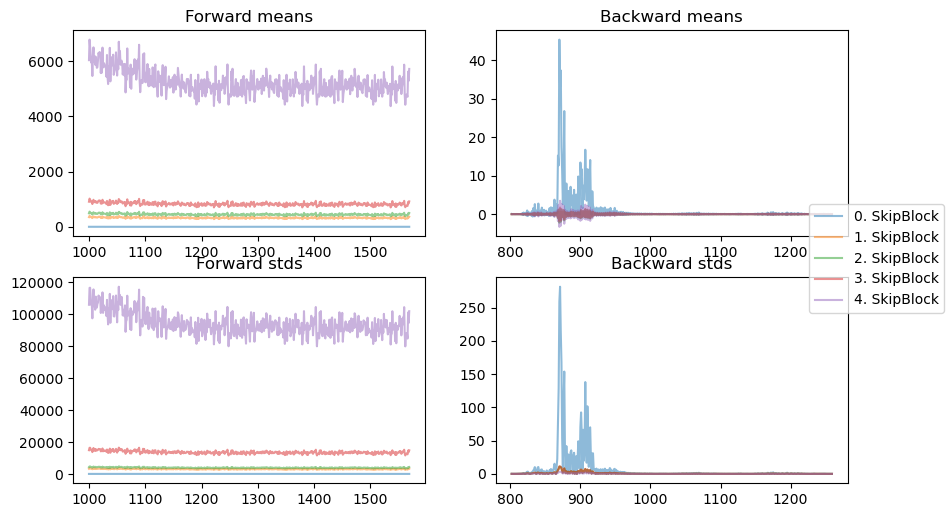

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [61]:
l.HookModule.plot()[1000:]

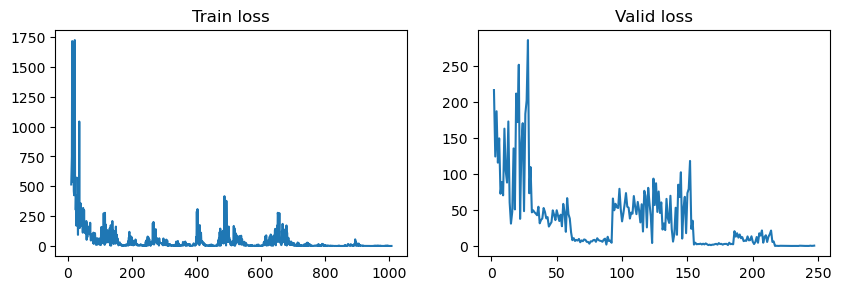

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [35]:
l.Loss.plot()[10:]

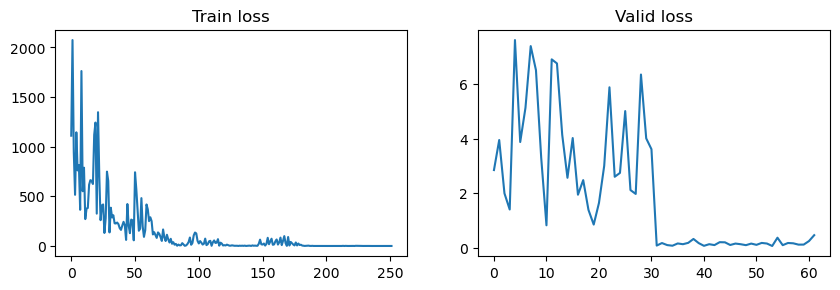

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [25]:
l.Loss.plot()

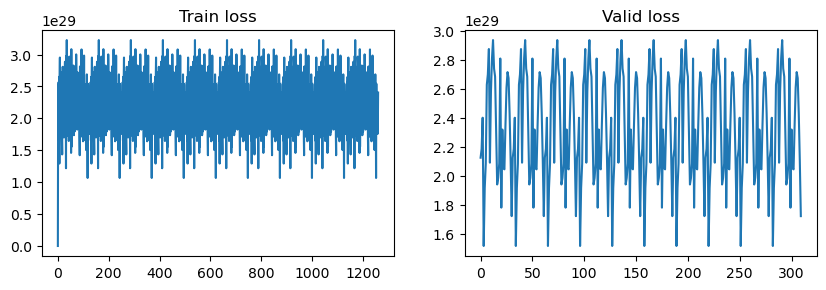

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [23]:
l.Loss.plot()